In [1]:
##########################################################
# パッケージの読み込みとエイリアスの設定
##########################################################
using Revise, LinearAlgebra, LaTeXStrings, Plots, CSV, DataFrames, JLD2, Random, Statistics, Distributions
using TensorCrossInterpolation
import TensorCrossInterpolation as TCI
using Tensor_FixedSeedMC
import Tensor_FixedSeedMC as TCIMC

In [2]:
function tci_oneshot(func, d, localdims, firstpivot, tol, maxiter)
    BLAS.set_num_threads(4)

    for isearch in 1:100
        p = TCI.optfirstpivot(func, localdims, firstpivot) # search optimal fist pivot
        if abs(func(p)) > abs(func(firstpivot))
            firstpivot = p
        end
    end

    # execute tci2
    qtt, ranks, errors = TCI.crossinterpolate2(
        Float64,
        func, 
        localdims, 
        [firstpivot], 
        tolerance = tol, 
        maxiter = maxiter, 
        verbosity = 1, 
        loginterval = 1,
        pivotsearch = :rook,
    )

    return qtt, errors
end  

tci_oneshot (generic function with 1 method)

In [3]:
##########################################################
# パラメータの設定とグリッド生成
##########################################################

Random.seed!(1234)
# d_normals = randn(Float64, N_STEPS * N_PATHS)

num_nodes = 100
index_ = Int(num_nodes/2)

S0_values = TCIMC.chebyshev_lobatto_nodes(90.0, 120.0, num_nodes)
implied_vol_values = TCIMC.chebyshev_lobatto_nodes(0.15, 0.25, num_nodes)
#T_values = TCIMC.calc_cheby_abscissas(0.1, 1.0, num_nodes)
r_values = TCIMC.chebyshev_lobatto_nodes(0.0, 0.1, num_nodes)
t_values = TCIMC.chebyshev_lobatto_nodes(0.0, 0.9, num_nodes)

101-element Vector{Float64}:
 0.0
 0.0002220478354207911
 0.0008879722072778207
 0.0019971159286140128
 0.0035483844084849836
 0.005540246732188059
 0.00797073717209007
 0.010837457127563732
 0.014137577492116082
 0.017867841445375676
 0.022024567667180917
 0.02660365397059855
 0.03160058135028687
 ⋮
 0.8733963460294014
 0.877975432332819
 0.8821321585546245
 0.8858624225078839
 0.8891625428724363
 0.89202926282791
 0.894459753267812
 0.896451615591515
 0.8980028840713861
 0.8991120277927223
 0.8997779521645792
 0.9

$$
d_{1/2} = \frac{\ln{(S_0 / K)} + (r \pm \sigma^2 / 2)(T-t)}{\sigma \sqrt{T-t} }
$$

In [4]:
using Distributions

"""
Black–Scholes option pricing formula.

Arguments:
    S : 現在の株価
    K : 行使価格
    r : 無リスク金利
    σ : ボラティリティ
    T : 残存期間（年単位）

Returns:
    (C, P) : コール価格とプット価格
"""
function black_scholes(S, K, r, σ, t, T)
    τ = T - t
    if τ <= 0
        # 満期を過ぎている場合はただのペイオフ
        return (max(S - K, 0.0), max(K - S, 0.0))
    end
    
    d1 = (log(S / K) + (r + 0.5 * σ^2) * τ) / (σ * sqrt(τ))
    d2 = d1 - σ * sqrt(τ)
    
    N = Normal(0,1)
    C = S * cdf(N, d1) - K * exp(-r * τ) * cdf(N, d2)
    P = K * exp(-r * τ) * cdf(N, -d2) - S * cdf(N, -d1)
    return C, P
end

T = 1.0
K = 100.0
d1(S0::Float64, σ::Float64, r::Float64,  t::Float64) = black_scholes(S0, K, r, σ, t, T)[1]

function d1_ind_pre(
    bits::Vector{Int}, 
    S0_values::Vector{Float64}, 
    implied_vol_values::Vector{Float64}, 
    r_values::Vector{Float64}, 
    t_values::Vector{Float64}
    )
    S0 = S0_values[bits[1]]
    σ = implied_vol_values[bits[2]]
    r = r_values[bits[3]]
    t = t_values[bits[4]]
    return d1(S0, σ, r, t)
end 

d1_ind(bits) = d1_ind_pre(bits, S0_values, implied_vol_values, r_values, t_values)

d1_ind (generic function with 1 method)

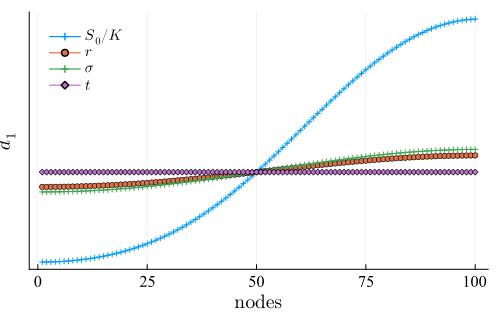

In [5]:
plot_d1 = plot(
    # yscale = :log,
    # xscale = :log,
    # title = L"\mathrm{QTT}~,~~d=10",
    xlabel = L"\mathrm{nodes}",
    ylabel = L"d_1",
    #markershape = :circle,
    titlefontsize = 17,
    legendfontsize = 10,
    tickfontsize = 10,
    xguidefont = 13,
    yguidefont = 13,
    #xlims = (0.6, 3.5),
    #xticks = 1:1:nbit*d-1,
    # ylims = (1, 2^(nbit*d*0.5)),
    yticks = [10^0, 10^2, 10^4, 10^6, 10^8],
    # legend = :inside,
    #size = (600, 450),
    #bottom_margin=Plots.Measures.Length(:mm, 3.0),
    bottom_margin=Plots.Measures.Length(:mm, 2.0),
    fontfamily = "Times New Roman",
    size = (500, 320),
    foreground_color_legend = nothing,
    background_color_legend = nothing,
)

plot!(
    plot_d1,
    [d1_ind([S0K_ind, index_, index_, index_]) for S0K_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"S_0 / K",
)

plot!(
    plot_d1,
    [d1_ind([index_, r_ind, index_,  index_]) for r_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"r",
)

plot!(
    plot_d1,
    [d1_ind([index_, index_, σ_ind,  index_]) for σ_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"\sigma",
)



plot!(
    plot_d1,
    [d1_ind([index_, index_, index_, index_]) for t_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"t",
)

In [6]:
##########################################################
# TCI のキャッシュ関数設定とワンショット補間の実行
##########################################################
# 関数 abo は asian_barrier_option_tci のラッパー（引数はインデックス）
#abo(j) = asian_barrier_option_tci(j, price_matrix_mc)
# abo_(j) = asian_barrier_option_tci(j, price_matrix_mc)

d = 4
num_points = num_nodes+1
localdims_d1 = fill(num_points, d)
firstpivot_d1 = rand(1:num_points, d)
d1_cf = TCI.CachedFunction{Float64}(d1_ind, localdims_d1)
tol_mc = 1e-7
tol = tol_mc
maxiter = 6
tci_time = @elapsed begin
    tt_tci, errors_asianbarrier = tci_oneshot(d1_cf, d, localdims_d1, firstpivot_d1, tol, maxiter)
end
##########################################################

Found 4 global pivots
iteration = 1, rank = 22, error= 0.0, maxsamplevalue= 31.194056614832704, nglobalpivot=4
  Rejected 4 global pivots added in the previous iteration, errors are [4.0338772944181756e-7, 3.758083888527608e-8, 8.881784197001252e-16, 1.9917846816319695e-8]
Found 0 global pivots
iteration = 2, rank = 24, error= 0.0, maxsamplevalue= 31.194056614832704, nglobalpivot=0
Found 0 global pivots
iteration = 3, rank = 23, error= 0.0, maxsamplevalue= 31.194056614832704, nglobalpivot=0
Found 0 global pivots
iteration = 4, rank = 23, error= 0.0, maxsamplevalue= 31.194056614832704, nglobalpivot=0


3.281302791

In [7]:
# TCI後のTTを評価
n = num_nodes
price_matrix_tci_S0K = zeros(n)
price_matrix_ex_S0K = zeros(n)
price_matrix_tci_sigma = zeros(n)
price_matrix_ex_sigma = zeros(n)
price_matrix_tci_r = zeros(n)
price_matrix_ex_r = zeros(n)
price_matrix_tci_t = zeros(n)
price_matrix_ex_t = zeros(n)

for i in 1:n
    price_matrix_tci_S0K[i] = TCIMC._evaluate(tt_tci.sitetensors, [i, index_, index_, index_, index_])
    price_matrix_ex_S0K[i] = d1_ind([i, index_, index_, index_])
    price_matrix_tci_sigma[i] = TCIMC._evaluate(tt_tci.sitetensors, [index_, i, index_, index_, index_])
    price_matrix_ex_sigma[i] = d1_ind([index_, i, index_, index_])
    price_matrix_tci_r[i] = TCIMC._evaluate(tt_tci.sitetensors, [index_, index_, i, index_])
    price_matrix_ex_r[i] = d1_ind([index_, index_, i, index_])
    price_matrix_tci_t[i] =  TCIMC._evaluate(tt_tci.sitetensors, [index_, index_, index_, i])
    price_matrix_ex_t[i] = d1_ind([index_, index_, index_, i])
end

ab_error_S0K = abs.(price_matrix_tci_S0K .- price_matrix_ex_S0K)
ab_error_sigma = abs.(price_matrix_tci_sigma .- price_matrix_ex_sigma)
rel_error_S0K = abs.(price_matrix_tci_S0K .- price_matrix_ex_S0K) ./ price_matrix_ex_S0K
rel_error_sigma = abs.(price_matrix_tci_sigma .- price_matrix_ex_sigma) ./ price_matrix_ex_sigma
ab_error_r = abs.(price_matrix_tci_r .- price_matrix_ex_r)
ab_error_t = abs.(price_matrix_tci_t .- price_matrix_ex_t)


println("==== TCI ====")
println("Max absolute error for S0K    : ", maximum(ab_error_S0K))
println("Max absolute error for sigma  : ", maximum(ab_error_sigma))
println("Max relative error for S0K    : ", maximum(rel_error_S0K))
println("Max relative error for sigma  : ", maximum(rel_error_sigma))
@show maximum(ab_error_r)
@show maximum(ab_error_t)
:

==== TCI ====
Max absolute error for S0K    : 2.288486890655861e-6
Max absolute error for sigma  : 5.095792303677626e-7
Max relative error for S0K    : 4.7194689855049964e-7
Max relative error for sigma  : 5.6430569815594614e-8
maximum(ab_error_r) = 9.437072474582919e-7
maximum(ab_error_t) = 1.158059864891925e-6


(::Colon) (generic function with 30 methods)

In [8]:
TCI.TensorTrain(tt_tci)

(::TensorTrain{Float64, 3}) (generic function with 1 method)

In [9]:
#M_dct = TCIMC.dct_matrix(n)
M_dct = TCIMC.chebyshev_coeff_matrix_from_lobatto_sorted(num_nodes)


function compute_chebyshev_coeff_2(tt::TCI.TensorTrain{T}, A::Vector{<:AbstractMatrix{T}}) where {T}
    d = length(tt.sitetensors)
    @assert d == length(A) "長さ不一致: length(tt)=$d vs length(A)=$(length(A))"

    new_cores = Vector{Array{T,3}}(undef, d)

    for k in 1:d
        G = tt.sitetensors[k]               # (r_{k-1}, n_k, r_k)
        r1, n, r2 = size(G)
        Ak = A[k]                           # (p_k, n_k)
        p, nA = size(Ak)
        @assert n == nA "第$k: サイズ不一致 n_k=$n vs size(A[$k],2)=$nA"

        Gnew = zeros(T, r1, p, r2)          # (r_{k-1}, p_k, r_k)

        # 物理次元方向への線形変換:  ∀(i1,i3) : Gnew[i1,:,i3] = A[k] * G[i1,:,i3]
        @inbounds for i1 in 1:r1, i3 in 1:r2
            # y = A * x（x は長さ n のスライス）
            @views x = G[i1, :, i3]
            @views y = Gnew[i1, :, i3]
            mul!(y, Ak, x)                  # y = Ak * x
        end

        new_cores[k] = Gnew
    end

    # ★ 外部コンストラクタで作る（型パラメータは書かない）
    return TCI.TensorTrain(new_cores)
end


C_coeff_tensor_tci = compute_chebyshev_coeff_2(TCI.TensorTrain(tt_tci), fill(M_dct, d))

(::TensorTrain{Float64, 3}) (generic function with 1 method)

In [10]:
#M_dct = TCIMC.dct_matrix(n)
#C_coeff_tensor_tci = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_tci), fill(M_dct, d))
#C_coeff_tensor_svd = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_svd), fill(M_dct, 2))

### 不明点

In [11]:
using Statistics, Random

num_nodes_equiv = 100
S0K_values_equiv = collect(range(90.0, stop=120.0, length=num_nodes_equiv))
implied_vol_values_equiv = collect(range(0.15, stop=0.25, length=num_nodes_equiv))
r_values_equiv = collect(range(0.0, stop=0.1, length=num_nodes_equiv))
t_values_equiv = collect(range(0.0, stop=0.9, length=num_nodes_equiv))

# 全インデックスの組を作成して、ランダムに100点抽出
Random.seed!(1234)
# all_idx_pairs = [(i, j, k, l, m) for i in 1:num_nodes, j in 1:num_nodes, k in 1:num_nodes, l in 1:num_nodes, m in 1:num_nodes]
num_nodes_equiv = 80
all_idx_pairs = collect(Iterators.product(1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv))
rand_idx_pairs = rand(vec(all_idx_pairs), 100)

# 解析解の関数
d1_ind_ex(bits) = d1_ind_pre(bits, S0K_values_equiv, implied_vol_values_equiv,  r_values_equiv, t_values_equiv)


price_dict_tci = Dict{NTuple{4, Int}, Float64}()
price_dict_ex = Dict{NTuple{4, Int}, Float64}()

for (i, j, l, m) in rand_idx_pairs
    s0_val   = S0K_values_equiv[i]
    vol_val  = implied_vol_values_equiv[j]
    r_val    = r_values_equiv[l]
    t_val    = t_values_equiv[m]

    #@show "s"

    weights = [
        TCIMC.cheb_basis_vector_weighted(90.0, 120.0, s0_val, num_nodes ),
        TCIMC.cheb_basis_vector_weighted(0.15, 0.25, vol_val, num_nodes ),
        TCIMC.cheb_basis_vector_weighted(0.0, 0.1, r_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted(0.0, 0.9, t_val, num_nodes)
    ]

   # @show "d"

    c = 1  # 初期コアから更新
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    # TCI
    price_dict_tci[(i, j, l, m)] = result_original
    # 解析解
    #@show "c"
    #price_dict_ex[(i, j, l, m)] = d1_ind_ex([i, j, l, m])
    price_dict_ex[(i, j, l, m)] = d1(s0_val, vol_val, r_val, t_val)
    #@show "cc"
end

In [12]:
@show price_dict_ex
@show price_dict_tci
;

price_dict_ex = Dict((25, 12, 8, 57) => 3.342582998269421, (61, 77, 17, 55) => 12.124094720094618, (72, 4, 16, 27) => 14.069689073296033, (72, 79, 62, 11) => 19.858291543265693, (74, 22, 67, 52) => 16.368113206095032, (12, 6, 31, 30) => 3.147012360777005, (24, 16, 41, 16) => 6.120956134434202, (62, 65, 50, 75) => 11.628059001584987, (31, 66, 39, 57) => 6.429707893498531, (43, 7, 45, 54) => 7.427271885616754, (53, 14, 44, 72) => 8.619409017880258, (74, 8, 61, 54) => 15.76082203144928, (39, 24, 52, 68) => 6.287868785252293, (29, 68, 75, 60) => 6.756926854769858, (57, 4, 31, 20) => 11.599874735118647, (75, 16, 64, 49) => 16.62221039836433, (67, 40, 30, 72) => 12.13528818483256, (65, 80, 20, 77) => 11.73324547533143, (47, 79, 42, 22) => 12.337329496659855, (31, 54, 48, 1) => 9.883783852874934, (77, 70, 66, 54) => 17.777142990948278, (52, 36, 40, 71) => 8.787077636450775, (18, 38, 22, 30) => 4.691810357125725, (4, 19, 10, 31) => 2.2277761855667926, (46, 10, 32, 39) => 8.489867755890351, (43

### 誤差評価

In [13]:
using Statistics

# 絶対誤差、相対誤差を保存する辞書
abs_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()
rel_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()

for key in keys(price_dict_tci)
    ex_val = price_dict_ex[key]
    @show ex_val
    tci_val = price_dict_tci[key]
    @show tci_val
    
    abs_err = abs(ex_val - tci_val)
    rel_err = abs_err / abs(ex_val) 
    
    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
rel_error_vals = collect(values(rel_errors_tci))

@show abs_error_vals
@show rel_error_vals

println("==== cheby ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))
println("Mean relative error   : ", mean(rel_error_vals)) #
println("Max  relative error   : ", maximum(rel_error_vals)) #

ex_val = 3.342582998269421
tci_val = 3.3425826587100365
ex_val = 12.124094720094618
tci_val = 12.124094356418425
ex_val = 14.069689073296033
tci_val = 14.069689442552791
ex_val = 19.858291543265693
tci_val = 19.85829147020783
ex_val = 16.368113206095032
tci_val = 16.36811321620065
ex_val = 3.147012360777005
tci_val = 3.147012154782173
ex_val = 6.120956134434202
tci_val = 6.120956554423978
ex_val = 11.628059001584987
tci_val = 11.628058484943088
ex_val = 6.429707893498531
tci_val = 6.42970719180765
ex_val = 7.427271885616754
tci_val = 7.427271324498045
ex_val = 8.619409017880258
tci_val = 8.619409167205616
ex_val = 15.76082203144928
tci_val = 15.760822297232293
ex_val = 6.287868785252293
tci_val = 6.2878682761019995
ex_val = 6.756926854769858
tci_val = 6.756927039284331
ex_val = 11.599874735118647
tci_val = 11.599874446580356
ex_val = 16.62221039836433
tci_val = 16.62221056136799
ex_val = 12.13528818483256
tci_val = 12.135288246040805
ex_val = 11.73324547533143
tci_val = 11.733246123451

## Delta

In [14]:
#import Pkg; Pkg.add("SpecialFunctions")

In [15]:
function bs_delta(S, K, r, σ, t, T; option::Symbol = :call)
    τ = T - t
    if τ <= 0
        # 満期時の慣習的な取り扱い（S=K は 0.5 とすることが多い）
        if option == :call
            return S > K ? 1.0 : (S < K ? 0.0 : 0.5)
        elseif option == :put
            return S > K ? 0.0 : (S < K ? -1.0 : -0.5)
        else
            error("option must be :call or :put")
        end
    end

    d1 = (log(S / K) + (r + 0.5 * σ^2) * τ) / (σ * sqrt(τ))
    N = Normal(0,1)
    if option == :call
        return cdf(N, d1)                # Δ_call
    elseif option == :put
        return cdf(N, d1) - 1.0          # Δ_put
    else
        error("option must be :call or :put")
    end
end

Delta2(S0::Real, σ::Real, r::Real, t::Real) = bs_delta(S0, K, r, σ, t, T)

Delta2 (generic function with 1 method)

In [16]:
#Delta_(S0::Real, σ::Real, T::Real, t::Real) = 1 / (S0 * σ * sqrt(T - t))
#Delta2(S0::Real, σ::Real, t::Real) = Delta_(S0, σ, 1.0, t)


In [17]:
# dφ_w/dx
function cheb_basis_vector_weighted_deriv(a::Real, b::Real, x::Real, n::Integer)
    n ≥ 1 || throw(ArgumentError("n must be ≥ 1"))
    b == a && throw(ArgumentError("b must be different from a"))

    # map x ∈ [a,b] to ẋ ∈ [-1,1]
    xhat = (2*float(x) - (a+b)) / (b-a)
    scale = 2 / (b - a)

    dφ = zeros(Float64, n+1)

    # φ[1] = 0.5*T0 = const ⇒ derivative = 0
    if n ≥ 1
        # φ[2] = T1(ẋ) = ẋ ⇒ derivative = scale
        dφ[2] = scale

        # U0=1, U1=2ẋ
        Ukm1 = 1.0
        Uk   = 2*xhat
        for k in 2:n-1
            # d/dx T_k = scale*k*U_{k-1}
            dφ[k+1] = scale*k*Ukm1
            # update U
            Ukp1 = 2*xhat*Uk - Ukm1
            Ukm1, Uk = Uk, Ukp1
        end
        # 最後の端点 (1/2)*T_n
        dφ[end] = 0.5 * scale * n * Ukm1
    end

    return dφ
end


cheb_basis_vector_weighted_deriv (generic function with 1 method)

In [18]:
# TT( G_k ∈ ℝ^{r_{k-1} × n_k × r_k} ) と
# v_modes = [v₁, v₂, ..., v_d]（各 v_k ∈ ℝ^{n_k}）の内積。
# ここで v は v₁ ⊗ v₂ ⊗ ... ⊗ v_d の分離形を仮定。
function tt_inner(tt_cores::Vector{<:Array{T,3}}, v_modes::Vector{<:AbstractVector{T}}) where {T<:Real}
    d = length(tt_cores)
    @assert d == length(v_modes) "次元数が一致しません: length(tt_cores)=$(d) vs length(v_modes)=$(length(v_modes))"

    # r₀ = 1 なので (1, r₀) から開始
    res = ones(T, 1, size(tt_cores[1], 1))

    for k in 1:d
        G = tt_cores[k]                            # (r_{k-1}, n_k, r_k)
        n_k = size(G, 2)
        @assert n_k == length(v_modes[k]) "第$(k)モードのサイズ不一致: n_k=$(n_k) vs length(v_modes[k])=$(length(v_modes[k]))"

        # 次の (1, r_k) を溜めるバッファ
        tmp = zeros(T, size(res, 1), size(G, 3))

        # 各 i_k について res * G[:, i_k, :] * v_k[i_k] を加算
        @inbounds for i in 1:n_k
            Gi = view(G, :, i, :)                  # (r_{k-1}, r_k)
            tmp .+= res * Gi * v_modes[k][i]
        end

        res = tmp                                  # (1, r_k)
    end

    @assert size(res, 2) == 1 "最終ランク r_d は1である必要がありますが、r_d=$(size(res,2))"
    return res[1]                                   # スカラー
end


tt_inner (generic function with 1 method)

In [19]:
using Statistics, Random

#num_nodes = n
# num_nodes_S0 = 300
num_nodes_equiv = 100
S0K_values_equiv = collect(range(90.0, stop=120.0, length=num_nodes_equiv))
implied_vol_values_equiv = collect(range(0.15, stop=0.25, length=num_nodes_equiv))
r_values_equiv = collect(range(0.0, stop=0.1, length=num_nodes_equiv))
t_values_equiv = collect(range(0.0, stop=0.9, length=num_nodes_equiv))

# 全インデックスの組を作成して、ランダムに100点抽出
Random.seed!(1234)
num_nodes_equiv = 80
all_idx_pairs = collect(Iterators.product(1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv))
rand_idx_pairs = rand(vec(all_idx_pairs), 100)

# 解析解の関数
# d1_ind_ex(bits) = d1_ind_pre(bits, S0K_values_equiv, implied_vol_values_equiv,  r_values_equiv, t_values_equiv)


price_dict_tci = Dict{NTuple{4, Int}, Float64}()
price_dict_ex = Dict{NTuple{4, Int}, Float64}()

for (i, j, l, m) in rand_idx_pairs
    s0_val   = S0K_values_equiv[i]
    vol_val  = implied_vol_values_equiv[j]
    r_val    = r_values_equiv[l]
    t_val    = t_values_equiv[m]

    #@show "s"

    weights = [
        TCIMC.cheb_basis_vector_weighted_derivative(90.0, 120.0, s0_val, num_nodes),
        #cheb_basis_vector_weighted_deriv(90.0, 120.0, s0_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted(0.15, 0.25, vol_val, num_nodes ),
        TCIMC.cheb_basis_vector_weighted(0.0, 0.1, r_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted(0.0, 0.9, t_val, num_nodes)
    ]

    c = 1  # 初期コアから更新
    #left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    #right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    #result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)
    result_original = tt_inner(C_coeff_tensor_tci.sitetensors, weights)

    # TCI
    price_dict_tci[(i, j, l, m)] = result_original
    # 解析解
    #price_dict_ex[(i, j, l, m)] = Delta(s0_val, vol_val, r_val, t_val)
    price_dict_ex[(i, j, l, m)] = Delta2(s0_val, vol_val, r_val, t_val)
    #@show "cc"
end

In [20]:
using Statistics

# 絶対誤差、相対誤差を保存する辞書
abs_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()
rel_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()

for key in keys(price_dict_tci)
    ex_val = price_dict_ex[key]
    #@show ex_val
    tci_val = price_dict_tci[key]
    #@show tci_val
    
    abs_err = abs(ex_val - tci_val)
    rel_err = abs_err / abs(ex_val) 
    
    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
rel_error_vals = collect(values(rel_errors_tci))

#@show abs_error_vals
##@show rel_error_vals

println("==== cheby ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))
println("Mean relative error   : ", mean(rel_error_vals)) #
println("Max  relative error   : ", maximum(rel_error_vals)) #

==== cheby ====
Mean absolute error   : 3.1103201739157704e-7
Max  absolute error   : 1.2249487524318425e-6
Mean relative error   : 5.57887608376215e-7
Max  relative error   : 3.46262061729383e-6


## Gamma

In [21]:
function bs_gamma(S, K, r, σ, t, T)
    τ = T - t
    if τ <= 0 || σ <= 0 || S <= 0
        return NaN   # 満期・ゼロボラ・非正のSでは定義が崩れるため
    end
    d1 = (log(S / K) + (r + 0.5 * σ^2) * τ) / (σ * sqrt(τ))
    ϕ = pdf(Normal(0,1), d1)
    return ϕ / (S * σ * sqrt(τ))
end

bs_gamma (generic function with 1 method)

In [22]:
Gamma(S0::Real, σ::Real, r::Real, t::Real) = bs_gamma(S0, K, r, σ, t, T)


num_nodes_equiv = 100
S0K_values_equiv = collect(range(90.0, stop=120.0, length=num_nodes_equiv))
implied_vol_values_equiv = collect(range(0.15, stop=0.25, length=num_nodes_equiv))
r_values_equiv = collect(range(0.0, stop=0.1, length=num_nodes_equiv))
t_values_equiv = collect(range(0.0, stop=0.9, length=num_nodes_equiv))

# 全インデックスの組を作成して、ランダムに100点抽出
Random.seed!(1234)
num_nodes_equiv = 80
all_idx_pairs = collect(Iterators.product(1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv))
rand_idx_pairs = rand(vec(all_idx_pairs), 100)

# 解析解の関数
# d1_ind_ex(bits) = d1_ind_pre(bits, S0K_values_equiv, implied_vol_values_equiv,  r_values_equiv, t_values_equiv)


price_dict_tci = Dict{NTuple{4, Int}, Float64}()
price_dict_ex = Dict{NTuple{4, Int}, Float64}()

for (i, j, l, m) in rand_idx_pairs
    s0_val   = S0K_values_equiv[i]
    vol_val  = implied_vol_values_equiv[j]
    r_val    = r_values_equiv[l]
    t_val    = t_values_equiv[m]

    #@show "s"

    weights = [
        TCIMC.cheb_basis_vector_weighted_second_derivative(90.0, 120.0, s0_val, num_nodes),
        #cheb_basis_vector_weighted_deriv(90.0, 120.0, s0_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted(0.15, 0.25, vol_val, num_nodes ),
        TCIMC.cheb_basis_vector_weighted(0.0, 0.1, r_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted(0.0, 0.9, t_val, num_nodes)
    ]

    c = 1  # 初期コアから更新
    #left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    #right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    #result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)
    result_original = tt_inner(C_coeff_tensor_tci.sitetensors, weights)

    # TCI
    price_dict_tci[(i, j, l, m)] = result_original
    # 解析解
    #price_dict_ex[(i, j, l, m)] = Delta(s0_val, vol_val, r_val, t_val)
    price_dict_ex[(i, j, l, m)] = Gamma(s0_val, vol_val, r_val, t_val)
    #@show "cc"
end

In [23]:
using Statistics

# 絶対誤差、相対誤差を保存する辞書
abs_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()
rel_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()

for key in keys(price_dict_tci)
    ex_val = price_dict_ex[key]
    #@show ex_val
    tci_val = price_dict_tci[key]
    #@show tci_val
    
    abs_err = abs(ex_val - tci_val)
    rel_err = abs_err / abs(ex_val) 
    
    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
rel_error_vals = collect(values(rel_errors_tci))

#@show abs_error_vals
#@show rel_error_vals
println("==== cheby ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))
println("Mean relative error   : ", mean(rel_error_vals)) #
println("Max  relative error   : ", maximum(rel_error_vals)) #

==== cheby ====
Mean absolute error   : 3.006084345698844e-7
Max  absolute error   : 1.9012204521308418e-6
Mean relative error   : 1.2717579076000124e-5
Max  relative error   : 6.891227492304647e-5


## Vega

In [24]:
#=
function bs_vega(S, K, r, σ, t, T; q::Float64=0.0)
    τ = T - t
    if τ <= 0 || σ <= 0 || S <= 0 || K <= 0
        # 満期では理論的に Vega → 0、パラメータ異常時は 0 を返す
        return (0.0, 0.0)
    end
    d1 = (log(S / K) + (r - q + 0.5 * σ^2) * τ) / (σ * sqrt(τ))
    ϕ  = pdf(Normal(0,1), d1)
    v  = exp(-q*τ) * S * ϕ * sqrt(τ)     # dPrice/dσ（σが+1.00 = +100%の変化）
    return (v, v/100)                    # vega1pct = σが+1%pt のときの価格変化
end
=#
function bs_vega(S, K, r, σ, t, T)
    τ = T - t
    if τ <= 0 || σ <= 0 || S <= 0
        return 0.0
    end
    
    d1 = (log(S / K) + (r + 0.5 * σ^2) * τ) / (σ * sqrt(τ))
    ϕ = pdf(Normal(0,1), d1)
    return S * ϕ * sqrt(τ)
end


bs_vega (generic function with 1 method)

In [25]:
Vega(S0::Real, σ::Real, r::Real, t::Real) = bs_vega(S0, K, r, σ, t, T)


num_nodes_equiv = 100
S0K_values_equiv = collect(range(90.0, stop=120.0, length=num_nodes_equiv))
implied_vol_values_equiv = collect(range(0.15, stop=0.25, length=num_nodes_equiv))
r_values_equiv = collect(range(0.0, stop=0.1, length=num_nodes_equiv))
t_values_equiv = collect(range(0.0, stop=0.9, length=num_nodes_equiv))

# 全インデックスの組を作成して、ランダムに100点抽出
Random.seed!(1234)
num_nodes_equiv = 80
all_idx_pairs = collect(Iterators.product(1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv))
rand_idx_pairs = rand(vec(all_idx_pairs), 100)

# 解析解の関数
# d1_ind_ex(bits) = d1_ind_pre(bits, S0K_values_equiv, implied_vol_values_equiv,  r_values_equiv, t_values_equiv)


price_dict_tci = Dict{NTuple{4, Int}, Float64}()
price_dict_ex = Dict{NTuple{4, Int}, Float64}()

for (i, j, l, m) in rand_idx_pairs
    s0_val   = S0K_values_equiv[i]
    vol_val  = implied_vol_values_equiv[j]
    r_val    = r_values_equiv[l]
    t_val    = t_values_equiv[m]

    #@show "s"

    weights = [
        #TCIMC.cheb_basis_vector_weighted_second_derivative(90.0, 120.0, s0_val, num_nodes),
        #cheb_basis_vector_weighted_deriv(90.0, 120.0, s0_val, num_nodes),
        #TCIMC.cheb_basis_vector_weighted(0.15, 0.25, vol_val, num_nodes ),
        TCIMC.cheb_basis_vector_weighted(90.0, 120.0, s0_val, num_nodes ),
        TCIMC.cheb_basis_vector_weighted_derivative(0.15, 0.25, vol_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted(0.0, 0.1, r_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted(0.0, 0.9, t_val, num_nodes)
    ]

    c = 1  # 初期コアから更新
    #left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    #right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    #result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)
    result_original = tt_inner(C_coeff_tensor_tci.sitetensors, weights)

    # TCI
    price_dict_tci[(i, j, l, m)] = result_original
    # 解析解
    #price_dict_ex[(i, j, l, m)] = Delta(s0_val, vol_val, r_val, t_val)
    price_dict_ex[(i, j, l, m)] = Vega(s0_val, vol_val, r_val, t_val)
    #@show "cc"
end

In [28]:
using Statistics

# 絶対誤差、相対誤差を保存する辞書
abs_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()
rel_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()

for key in keys(price_dict_tci)
    ex_val = price_dict_ex[key]
    #@show ex_val
    tci_val = price_dict_tci[key]
    #@show tci_val
    
    abs_err = abs(ex_val - tci_val)
    rel_err = abs_err / abs(ex_val) 
    
    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
rel_error_vals = collect(values(rel_errors_tci))

#@show abs_error_vals
#@show rel_error_vals
println("==== cheby ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))
println("Mean relative error   : ", mean(rel_error_vals)) #
println("Max  relative error   : ", maximum(rel_error_vals)) #

==== cheby ====
Mean absolute error   : 2.3779851508383132e-5
Max  absolute error   : 0.00021625080297482668
Mean relative error   : 9.199703707613625e-7
Max  relative error   : 8.388669636509795e-6


In [29]:
"""
Black–Scholes rho (∂OptionPrice/∂r).
コールとプットの Rho を返す。
"""
function bs_rho(S, K, r, σ, t, T)
    τ = T - t
    if τ <= 0
        return (0.0, 0.0)
    end
    d1 = (log(S / K) + (r + 0.5 * σ^2) * τ) / (σ * sqrt(τ))
    d2 = d1 - σ * sqrt(τ)
    N = Normal(0,1)
    
    rho_call = K * τ * exp(-r * τ) * cdf(N, d2)
    rho_put  = -K * τ * exp(-r * τ) * cdf(N, -d2)
    
    return rho_call, rho_put
end

bs_rho

In [31]:
Rho(S0::Real, σ::Real, r::Real, t::Real) = bs_rho(S0, K, r, σ, t, T)[1]


num_nodes_equiv = 100
S0K_values_equiv = collect(range(90.0, stop=120.0, length=num_nodes_equiv))
implied_vol_values_equiv = collect(range(0.15, stop=0.25, length=num_nodes_equiv))
r_values_equiv = collect(range(0.0, stop=0.1, length=num_nodes_equiv))
t_values_equiv = collect(range(0.0, stop=0.9, length=num_nodes_equiv))

# 全インデックスの組を作成して、ランダムに100点抽出
Random.seed!(1234)
num_nodes_equiv = 80
all_idx_pairs = collect(Iterators.product(1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv))
rand_idx_pairs = rand(vec(all_idx_pairs), 100)

# 解析解の関数
# d1_ind_ex(bits) = d1_ind_pre(bits, S0K_values_equiv, implied_vol_values_equiv,  r_values_equiv, t_values_equiv)


price_dict_tci = Dict{NTuple{4, Int}, Float64}()
price_dict_ex = Dict{NTuple{4, Int}, Float64}()

for (i, j, l, m) in rand_idx_pairs
    s0_val   = S0K_values_equiv[i]
    vol_val  = implied_vol_values_equiv[j]
    r_val    = r_values_equiv[l]
    t_val    = t_values_equiv[m]

    #@show "s"

    weights = [
        #TCIMC.cheb_basis_vector_weighted_second_derivative(90.0, 120.0, s0_val, num_nodes),
        #cheb_basis_vector_weighted_deriv(90.0, 120.0, s0_val, num_nodes),
        #TCIMC.cheb_basis_vector_weighted(0.15, 0.25, vol_val, num_nodes ),
        TCIMC.cheb_basis_vector_weighted(90.0, 120.0, s0_val, num_nodes ),
        #TCIMC.cheb_basis_vector_weighted_derivative(0.15, 0.25, vol_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted(0.15, 0.25, vol_val, num_nodes ),
        #TCIMC.cheb_basis_vector_weighted(0.0, 0.1, r_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted_derivative(0.0, 0.1, r_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted(0.0, 0.9, t_val, num_nodes)
    ]

    c = 1  # 初期コアから更新
    #left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    #right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    #result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)
    result_original = tt_inner(C_coeff_tensor_tci.sitetensors, weights)

    # TCI
    price_dict_tci[(i, j, l, m)] = result_original
    # 解析解
    #price_dict_ex[(i, j, l, m)] = Delta(s0_val, vol_val, r_val, t_val)
    price_dict_ex[(i, j, l, m)] = Rho(s0_val, vol_val, r_val, t_val)
    #@show "cc"
end

In [32]:
using Statistics

# 絶対誤差、相対誤差を保存する辞書
abs_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()
rel_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()

for key in keys(price_dict_tci)
    ex_val = price_dict_ex[key]
    #@show ex_val
    tci_val = price_dict_tci[key]
    #@show tci_val
    
    abs_err = abs(ex_val - tci_val)
    rel_err = abs_err / abs(ex_val) 
    
    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
rel_error_vals = collect(values(rel_errors_tci))

#@show abs_error_vals
#@show rel_error_vals
println("==== cheby ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))
println("Mean relative error   : ", mean(rel_error_vals)) #
println("Max  relative error   : ", maximum(rel_error_vals)) #

==== cheby ====
Mean absolute error   : 3.6941243589012626e-5
Max  absolute error   : 0.00016197431571640664
Mean relative error   : 1.4143231742373977e-6
Max  relative error   : 8.123500262938228e-6


In [34]:
"""
Black–Scholes Theta (∂OptionPrice/∂t).
コールとプットの Theta を返す。
"""
function bs_theta(S, K, r, σ, t, T)
    τ = T - t
    if τ <= 0
        return (0.0, 0.0)
    end
    d1 = (log(S / K) + (r + 0.5 * σ^2) * τ) / (σ * sqrt(τ))
    d2 = d1 - σ * sqrt(τ)
    N = Normal(0,1)

    ϕ = pdf(N, d1)
    theta_call = -(S * ϕ * σ) / (2*sqrt(τ)) - r * K * exp(-r*τ) * cdf(N, d2)
    theta_put  = -(S * ϕ * σ) / (2*sqrt(τ)) + r * K * exp(-r*τ) * cdf(N, -d2)

    return theta_call, theta_put
end
Theta(S0::Real, σ::Real, r::Real, t::Real) = bs_theta(S0, K, r, σ, t, T)[1]

Theta (generic function with 1 method)

In [35]:
Rho(S0::Real, σ::Real, r::Real, t::Real) = bs_rho(S0, K, r, σ, t, T)[1]


num_nodes_equiv = 100
S0K_values_equiv = collect(range(90.0, stop=120.0, length=num_nodes_equiv))
implied_vol_values_equiv = collect(range(0.15, stop=0.25, length=num_nodes_equiv))
r_values_equiv = collect(range(0.0, stop=0.1, length=num_nodes_equiv))
t_values_equiv = collect(range(0.0, stop=0.9, length=num_nodes_equiv))

# 全インデックスの組を作成して、ランダムに100点抽出
Random.seed!(1234)
num_nodes_equiv = 80
all_idx_pairs = collect(Iterators.product(1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv))
rand_idx_pairs = rand(vec(all_idx_pairs), 100)

# 解析解の関数
# d1_ind_ex(bits) = d1_ind_pre(bits, S0K_values_equiv, implied_vol_values_equiv,  r_values_equiv, t_values_equiv)


price_dict_tci = Dict{NTuple{4, Int}, Float64}()
price_dict_ex = Dict{NTuple{4, Int}, Float64}()

for (i, j, l, m) in rand_idx_pairs
    s0_val   = S0K_values_equiv[i]
    vol_val  = implied_vol_values_equiv[j]
    r_val    = r_values_equiv[l]
    t_val    = t_values_equiv[m]

    #@show "s"

    weights = [
        #TCIMC.cheb_basis_vector_weighted_second_derivative(90.0, 120.0, s0_val, num_nodes),
        #cheb_basis_vector_weighted_deriv(90.0, 120.0, s0_val, num_nodes),
        #TCIMC.cheb_basis_vector_weighted(0.15, 0.25, vol_val, num_nodes ),
        TCIMC.cheb_basis_vector_weighted(90.0, 120.0, s0_val, num_nodes ),
        #TCIMC.cheb_basis_vector_weighted_derivative(0.15, 0.25, vol_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted(0.15, 0.25, vol_val, num_nodes ),
        #TCIMC.cheb_basis_vector_weighted(0.0, 0.1, r_val, num_nodes),
        #TCIMC.cheb_basis_vector_weighted_derivative(0.0, 0.1, r_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted(0.0, 0.1, r_val, num_nodes),
        #TCIMC.cheb_basis_vector_weighted(0.0, 0.9, t_val, num_nodes)
        TCIMC.cheb_basis_vector_weighted_derivative(0.0, 0.9, t_val, num_nodes)
    ]

    c = 1  # 初期コアから更新
    #left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    #right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    #result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)
    result_original = tt_inner(C_coeff_tensor_tci.sitetensors, weights)

    # TCI
    price_dict_tci[(i, j, l, m)] = result_original
    # 解析解
    #price_dict_ex[(i, j, l, m)] = Delta(s0_val, vol_val, r_val, t_val)
    price_dict_ex[(i, j, l, m)] = Theta(s0_val, vol_val, r_val, t_val)
    #@show "cc"
end

In [36]:
using Statistics

# 絶対誤差、相対誤差を保存する辞書
abs_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()
rel_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()

for key in keys(price_dict_tci)
    ex_val = price_dict_ex[key]
    #@show ex_val
    tci_val = price_dict_tci[key]
    #@show tci_val
    
    abs_err = abs(ex_val - tci_val)
    rel_err = abs_err / abs(ex_val) 
    
    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
rel_error_vals = collect(values(rel_errors_tci))

#@show abs_error_vals
#@show rel_error_vals
println("==== cheby ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))
println("Mean relative error   : ", mean(rel_error_vals)) #
println("Max  relative error   : ", maximum(rel_error_vals)) #

==== cheby ====
Mean absolute error   : 3.692187390775814e-6
Max  absolute error   : 3.2226301931892465e-5
Mean relative error   : 5.741103717163345e-7
Max  relative error   : 4.412562817084486e-6
